# **Software Builder Agent : Intent → Design → Execution**


In [1]:
from langchain_community.agent_toolkits import FileManagementToolkit
from typing import Optional, List, TypedDict, Annotated
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field, ConfigDict
from langchain.agents import create_agent
from langchain_groq import ChatGroq
import os

## **Pydantic Schemas**


In [2]:
class PlanSchema(BaseModel):
    """
    High-level plan of the project.
    Defines WHAT to build.
    Output of Planner → Input to Architect.
    """

    name: str = Field(
        description="Name of the application"
    )

    description: str = Field(
        description="One-line description of the app to be built"
    )

    techstack: List[str] = Field(
        description="Technologies or programming languages to use"
    )

    features: List[str] = Field(
        description="List of core features the application should have"
    )


class FileSpec(BaseModel):
    """
    Specification for a file in the project.
    """

    file_name: str = Field(
        description="Name of the file to create, e.g. app.py, main.py"
    )

    purpose: str = Field(
        description="What this file is responsible for"
    )


class ArchitectureSchema(BaseModel):
    """
    Project structure and design.
    Defines HOW to build the app.
    Output of Architect → Input to Coder/Executor.
    """

    folder_structure: List[str] = Field(
        description="List of folders to create in the project"
    )

    files: List[FileSpec] = Field(
        description="Files to create with their responsibilities"
    )

    dependencies: List[str] = Field(
        description="External libraries or packages required"
    )

    entry_point: str = Field(
        description="Main file used to start the application, e.g. app.py"
    )

    run_command: str = Field(
        description="Command to run the project, e.g. python app.py"
    )

## **Agent State**


In [3]:
class AgentState(TypedDict):
    user_prompt: str
    plan: PlanSchema
    architecture: ArchitectureSchema

## **Prompts**


In [4]:
PLANNER_PROMPT = """
You are the PLANNER agent.

Your job is to convert the user request into a high-level software project plan.

You must generate:

1. name → Name of the application
2. description → One-line description of the app
3. techstack → List of technologies or languages to use
4. features → List of core features the application should have

RULES:
- Focus only on WHAT to build, not HOW to build it.
- Do NOT define files or folders.
- Do NOT define architecture or implementation details.
- Keep the plan clear and actionable.
- Use simple and practical technologies.

Your output will be passed to an ARCHITECT agent.
Return structured output matching PlanSchema.
"""


ARCHITECT_PROMPT = """
You are the ARCHITECT agent.

You receive a project plan from the PLANNER agent.
Your job is to design the technical structure of the project.

You must generate:

1. folder_structure → list of folders to create
2. files → list of files with their purpose
3. dependencies → external libraries required
4. entry_point → main file that starts the app
5. run_command → command to run the project

RULES:
- Define a clean and simple project structure.
- Ensure files support all features in the plan.
- Use minimal but practical structure.
- Keep naming consistent.
- Do NOT generate code.
- Do NOT generate implementation tasks.
- Focus only on project structure.

Return structured output matching ArchitectureSchema.
"""


CODER_SYSTEM_PROMPT = """
You are a SOFTWARE EXECUTION agent.

Your job is to implement the project using the provided architecture.
You must use file system tools to create folders and files. you can create, read, write, update, delete, copy, move and list files.

Your responsibilities:
- Create folder structure.
- Create all files.
- Write complete code in each file.
- Ensure the project runs using the given run command.

RULES:
- Always follow the architecture exactly.
- Always use tools to perform actions (do not just explain).
- Create full file content, not partial snippets.
- If a file exists, update it completely.
- Keep code clean and runnable.
- Ensure imports and module connections work.
- Do not ask questions. Execute the plan.

The user should see real files created on disk.
"""

### LLM


In [5]:
llm = ChatGroq(model="openai/gpt-oss-120b")

## **Nodes**


In [6]:
# planner node
def planner_node(state: AgentState):

    user_input = state["user_prompt"]

    prompt = ChatPromptTemplate.from_messages([
        ("system", PLANNER_PROMPT),
        ("user", "User Request: {user_input}")
    ])

    planner_llm = llm.with_structured_output(PlanSchema)

    chain = prompt | planner_llm

    response = chain.invoke({"user_input": user_input})

    return {"plan": response}


# architect node
def architect_node(state: AgentState):

    # get planner output
    plan = state["plan"]

    # convert plan to text (LLM needs context)
    plan_context = f"""
    Project Name: {plan.name}
    Description: {plan.description}
    Tech Stack: {", ".join(plan.techstack)}
    Features: {", ".join(plan.features)}
    """

    # create prompt
    prompt = ChatPromptTemplate.from_messages([
        ("system", ARCHITECT_PROMPT),
        ("user", "Project Plan:\n{plan_context}")
    ])

    architect_llm = llm.with_structured_output(ArchitectureSchema)

    chain = prompt | architect_llm

    response = chain.invoke({"plan_context": plan_context})

    return {"architecture": response}

### **Coder/Executor Node**


In [7]:
working_dir = os.getcwd()

toolkit = FileManagementToolkit(root_dir=str(working_dir))

executor_agent = create_agent(
    model=llm,
    tools=toolkit.get_tools(),
    system_prompt=CODER_SYSTEM_PROMPT
)

In [8]:
# executor node (OPTION A - no dependency installation)

def executor_node(state: AgentState):

    architecture = state.get("architecture")
    if not architecture:
        print("No architecture found.")
        return {}

    # format file list nicely for LLM
    files_info = "\n".join(
        f"- {file.file_name}: {file.purpose}"
        for file in architecture.files
    )

    # format dependencies (optional)
    dependencies_info = "\n".join(architecture.dependencies)

    execution_instructions = f"""
    Execute the following project architecture.

    STEP 1: Create all folders first.
    Folder structure:
    {architecture.folder_structure}

    STEP 2: Create all files with full implementation.
    Files to create:
    {files_info}

    STEP 3: If dependencies are provided, create a requirements.txt file listing them.
    Dependencies:
    {dependencies_info}

    Entry point:
    {architecture.entry_point}

    Ensure the project runs using:
    {architecture.run_command}

    IMPORTANT RULES:
    - Always use file tools to create or modify files.
    - Create complete file content (not partial code).
    - Ensure all files work together.
    """

    response = executor_agent.invoke({
        "messages": [{"role": "user", "content": execution_instructions}]
    })

    print("Executor Agent output:", response["messages"][-1].content)

    return {}

## **Building the Graph**


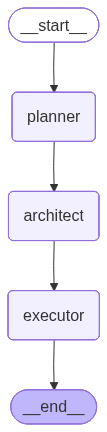

In [9]:
graph = StateGraph(AgentState)

graph.add_node("planner", planner_node)
graph.add_node("architect", architect_node)
graph.add_node("executor", executor_node)

graph.add_edge(START, "planner")
graph.add_edge("planner", "architect")
graph.add_edge("architect", "executor")
graph.add_edge("executor", END)

app = graph.compile()
app

In [10]:
user_input = "build a calculator app in python with CLI interface in a separate folder named 'calculator_app'"

response = app.invoke({
    "user_prompt": user_input,
})

Executor Agent output: Implemented the full project structure:

- Created `calccli` package with `__init__.py`, `__main__.py`, `calculator.py`, and `cli.py`.
- Developed a safe arithmetic expression evaluator using `ast`.
- Added a Click‑based CLI supporting REPL and one‑off evaluation.
- Added `tests` package with comprehensive unit tests for the calculator.
- Provided `requirements.txt` listing the `click` dependency.

The project can now be run with:

```bash
python -m calccli
```

and tests can be executed via:

```bash
python -m unittest discover
```


In [11]:
response

{'user_prompt': "build a calculator app in python with CLI interface in a separate folder named 'calculator_app'",
 'plan': PlanSchema(name='CalcCLI', description='A command‑line calculator application built in Python.', techstack=['Python 3.11+', 'argparse (standard library) or click for CLI parsing', 'unittest for testing'], features=['Parse and evaluate arithmetic expressions (addition, subtraction, multiplication, division, exponentiation).', 'Support for parentheses to control operation precedence.', 'Interactive REPL mode and one‑off expression mode via command line arguments.', 'Help command displaying usage and supported operators.', 'Graceful error handling for invalid input or division by zero.', 'Unit tests covering core calculation logic.']),
 'architecture': ArchitectureSchema(folder_structure=['calccli', 'tests'], files=[FileSpec(file_name='calccli/__init__.py', purpose='Marks the directory as a Python package and defines package‑level metadata.'), FileSpec(file_name='cal